In [ ]:
# Import libraries for data analysis
import pandas as pd
from summarytools import dfSummary

# Import libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Other libraries
import warnings

# Set pandas options
pd.set_option('future.no_silent_downcasting', True)
pd.set_option('display.max_columns', None)

# Ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Part I: Exploratory Data Analysis

This part of my work mainly focuses on understanding the underlying data and various relationships between different attributes


In [2]:
df = pd.read_csv('data/train_file.csv')
df.sample(n=5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y
25732,54,entrepreneur,divorced,university.degree,no,yes,yes,telephone,nov,thu,761,3,0,nonexistent,no
2783,51,blue-collar,married,basic.9y,unknown,no,no,telephone,may,fri,304,2,0,nonexistent,no
15584,27,services,single,professional.course,no,yes,yes,telephone,may,tue,271,1,0,nonexistent,no
11480,25,housemaid,single,high.school,no,no,no,cellular,jul,wed,1156,1,0,nonexistent,no
32210,46,student,single,unknown,no,yes,no,telephone,jul,fri,279,4,0,nonexistent,yes


In [3]:
dfSummary(data=df, is_collapsible=True)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,age[int64],Mean (sd) : 40.0 (10.4)min < med < max:17.0 < 38.0 < 98.0IQR (CV) : 15.0 (3.8),75 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAqJJREFUeJzt3T9v2kAYgPG72olciAzIEWxeGSJ1YPTSb5AP27VbBnYkvoE3JDAgKA7+V12kdmql2DHhXvP89jNW9MiynXtBV1WlANt9ufYJAO/hKotprb8qpe4bLj9XVXVq+ZRwJa7NkQZB8Oz7/qjJ+v1+n2itfxBrN1gbqrmSmkijKDoNBoO0zsLdbufN5/PRer02V2NC7QCbQ31jIh2Px78aLDW3DegI1+J7TL8sy7uWTwlCubbeY2ZZ5hVF8ZSm6YtSqskVFR3i2niPacRxPFoul708z53LnB4kcW29x0yShHtM/MULf4hAqBCBUCECoUIEQoUIhAoRCBUiECpEIFSIQKgQgVAhAqFCBEKFCIQKEawfRWmqKAozHeBrrZsegilWi3Qy1OPxeJdl2bcwDB3HcWpv2jaYYrVLJ0M9n8+u53m92WyWTiaTpO56pljt08lQ/+j3+00nWA0mDCzCwxREIFSIQKgQgVAhAqFCBEKFCIQKEQgVIhAqROj0f6auuKmFDS0tI9QLbGphQ0v7CLXlTS1saLkMQr3MphY2tLSMhymIQKgQgVAhAqFCBEKFCIQKEQgVIhAqRCBUiECoEIFQIQKhQgRChQiEChEIFSIQKkQgVIhAqBCBUNGNmSmttZn/MYNqdfllWZqR45vDqPUnh2oiDYLg2ff9Ud0DZ1nmFUXxlKbpi1Kq6bc+i8Oo9XWuqPcm0iiKToPBoNYfPY7j0XK57OV57qgbwqj1FcelTaR1x4aTJLnpkWFGrdvFwxREIFSIQKgQga/0sQw/jflvhNqxn8bcbrcHrfVPpVTapcjd9742qXvgw+HwtuZ4PHqr1ar3meulfvZms3kwr7am06keDoevDSJ9WCwW38MwfGwS+gcj/6jXqqr++7m/AfUtNx0LVAeCAAAAAElFTkSuQmCC"">",0(0.0%)
2,job[object],1. admin.2. blue-collar3. technician4. services5. management6. retired7. entrepreneur8. self-employed9. housemaid10. unemployed11. other,"8,305 (25.2%)7,430 (22.6%)5,392 (16.4%)3,192 (9.7%)2,343 (7.1%)1,364 (4.1%)1,159 (3.5%)1,098 (3.3%)855 (2.6%)798 (2.4%)974 (3.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA9RJREFUeJzt3TFuE0EAhtE1shA0jiJLOUwOwWE5RG4TobggiMZoWiog62+HzXtFhGhw8WmsXc0fDtfrdYHCh+RfAbFREhsZsZERGxmxkREbGbGRERuZw7Isn5dl+bjM6ef1en3d+kOwjuP5fP5yOp3ulwldLpdvh8Phq+D24ThCe3x8fL27u/uxTOTl5eXT09PT/fPz8zh1xbYDx/FjhPbw8PB9mc/4imcnPCCQERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERvtFaNxd2yZzIyfibc5jtuw45LijHfHxmcbV8O3/hyswwaBzMGvzOK9nmxOsh2bal1lTbVv06yrrKn2b7Z11XRPxKzHS10yYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzbe3+Blhs/AOxq8GLjsm2vhZAxe2N3J5sSiGbwYspAMXgxZqAcvmz/psj0vdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2NjP4MWQhXTwYsjC4Fo4GYMXMh4Q+G++Rn090qyrrKZI1lVWU9TrKqsp/pgHBDJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNuZfV1lNka6rrKb4G66Fk7GuYtqTzUlGM3gxcCEZvBi4UA9eDFz4Z17qkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxMd/gxcCFdPBi4MJbuBZOxuCFKU42pxjN4MW4hWTwYtxCPXgxbmFVXuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERvbrqssqUjXVZZUrM0GgYx1FZufbE41mnWVZRXJusqyinpdZVnF6rzUJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiY7vBi7EL6eDF2IVbcC2cjMELGScbGYMXMgYvZAxeyHipS0ZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxnXwskYvJDxgMCmX6O+QmnWVZZVJOsqyyrqdZVlFTfhAYGM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI1t1lWWVaTrKssqbsW1cDLWVWScbGQMXsgYvJAxeCHjpS4ZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9kXAsnY/BCxn+UxnaDl8HohZsPXsZfGL1QDl4GoxdW56UuGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREb2wxefv8z3HTwMhi9cAuuhZMxeCHjAYGM2MiIjYzYyIiNjNjIiI2M2MiIjaXyCzy9TuLOK9JUAAAAAElFTkSuQmCC"">",0(0.0%)
3,marital[object],1. married2. single3. divorced4. unknown,"19,929 (60.6%)9,245 (28.1%)3,671 (11.2%)65 (0.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABcCAYAAAB5jMeAAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAeFJREFUeJzt28Ft20AURdEZQ3DijQRDgEpIelARKTZFqAj3IBjiIk68YTAdZJNHDP85C29JGBeiKMzr67o2SHiKXAXERlJvrb201p6jV2X4XNf1oxVyOJ/PP47H4+vWN1LNsizvvfeflYI7jNCu1+vH6XT6vfXNVPF4PL7ebrfX+/0+nih1Yht/RmiXy+XX1jdTzEsrxgsCMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsZE99TGOvOQuyaPo//swDvGNs1UVj7xsaVmW93FatxXiWPh2Piud0h26KR8pXhCImfExWu7xsxfTrasqrpL2Yqp1VdVV0l7MuK7yE82kvCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2aqKd8s98lOpnwVJ3B7YYNAjCkf032y+bQhs66yeCKyrrJ4Ir2umuJNlm35UZcYsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEb86yrLJ6IrqssnvgXNgjEWFcR

In [109]:
print('Columns with de-facto missing values:')       
df.columns[df.isin(['unknown']).any()].tolist()

Columns with de-facto missing values:


['job', 'marital', 'education', 'default', 'housing', 'loan']

#### **Initial impressions and take-aways**

####  *Attributes and their possible meanings*

<details>

| **Column**    | **Column's meaning (*presumably !!!*)** |
|---------------|------------------------|
| age           | Current age of a person |
| job           | Job category to which person's profession falls into |
| marital       | Marital Status of a client |
| education     | Level of education that a contacted person has achieved so far |
| default       | Column indicating if this person had credit defaults in the past? |
| housing       | Column indicating whether a client posesses own real estate property? Alternatively, this could also indicate whether a contacted person has an on-going mortgage loan. Not sure about which one is correct (if any)|
| loan          | Column indicating whether an individual had any active/remaining loans at that moment?|
| contact       | Phone type that contacted person uses ('cellular', 'telephone') |
| month         | Month when contact took place |
| day_of_week   | Weekday when contact took place |
| duration      | Call duration? (probably in seconds) |
| campaign      | Number of phone calls made during current campaign? |
| previous      | Number of phone calls made during previous campgaign?|
| poutcome      | Outcome of the previous marketing campaign? ('success', 'failure', 'other', 'unknown') |
| y             | Target column, indicating whether a given person has agreed to make a deposit |

</details>

#### *Issues and flaws of the original dataset*

<details>

In theory, any dataset can potentially suffer from the following problems that (depending on severity) can seriously limit the ability to make meaninglful prediction:

    - Insufficient sample size
    - Non-representativeness of training data (i.e. sampling bias)    
    - Non-informative features(ex: irrelevant variables, absence of variation)
    - Poor-quality content (ex: ambiguity of values, abundance of outliers and/or missing values, noise)

>Is any of those issues is present in this case? Let's explore it. 

An initial analysis quickly reveals that this dataset contains (at least) the following flaws and inconsistencies that should be adressed:

1. All categorical attributes are stored as objects (i.e. text-data).

2. 8 rows are full duplicates of already existing rows.

3. Although at first glance, there seem to be no missing values, some columns
like ```marital```, ```education```, ```housing``` etc. contain value called *unknown*, which in its essense is equivalent to N/A since it does not provide us any useful meaning on its own. Neither can we regard it as category on its own. 

4. Column ```default``` has almost zero variability (hence, not informative). This is indeed a problem, since only few intances of **yes** are neither sufficient for training data nor for making any meaningful judgements. This handicap therefore makes use of ```default``` column meaningless.

5. Columns ```education``` and ```job``` consists of many categories that despite having the same meaning and describing the same phenomenon, are nevertheless splitted into different categories. I believe this degree of granularity unnecesarily introduces an extra layer of complexity and reduces useful training data size. Yet, it brings no informativeness in practical terms. For instance, does anyone really believe that there is a drastic difference between categories "illeteral", "basic.4y" and "basic.6y"? Is the difference among them really big enough to justify splitting them into different groups? I don't think so. Similarly, don't "blue-collar" and "technician" represent the same job category?

6. Problems, somewhat similar to those described in previous 2 points also exist in some other columns. For instance, columns ```previous```, ```poutcome```,  ```month``` etc. all seem to be heavily skewed. 

7. In addition to being heavily imbalanced, ```month``` also does not contain two months: "January" and "February". This sort of data incompleteness leads to mutiple issues (if parameter "month" is used for predictions), the biggest being: * What if in the future a campaign is launched in January or February?* 

8. It look like call duration is measured in seconds. But is this level of granularity necessary? Is there a big difference between 120 and 145 seconds for example? Or between 1 and 35 seconds? It might actually be more meaningful to convert those values into minutes to make differences in call durations more obvious.

In short, main problems present in the original version of the dataset can be attributed to:
 - Presence of outliers
 - Scarce presence of certain values
 - Noise caused by over-detalization



Ideally, all of those issues should be resolved via taking into consideration the bank's underlying context and cicrumstances under which data was collected. But, given that this kind of information is beyond of my reach, the next best thing I can do is to make plausible assumptions and proceed with them, hoping that my guesses resembly the reality close enough. In the later part of this notebook, I will present my approach.

</details>

*Short overview of flaws and problems associated with features*

<details>

| **Column**    | **Possible issues (minor and big) and risks associated** |
|---------------|------------------------|
| age           | presence of outliers |
| job           | over-granularity, lack of standartized options,  missing values |
| marital       | Missing values |
| education     | over-granularity,  missing values |
| default       | no-variability of data (almost all values are "no"), missing values |
| housing       | missing values |
| loan          | missing values|
| month         | not all months are present, distribution of values is highly skewed |
| duration      | over-granularity, truncation might be necessary to minimize the effect of outliers |
| campaign      | truncation might be necessary to minimize the effect of outliers |
| previous      | imbalanced data, truncation might be necessary to minimize the effect of outliers|
| poutcome      | imbalanced data |
| y             | imbalanced data |

</details>

#### Part II: Fixing flaws and making data more informative

> Remark:  In order to keep this Notebook neat and tidy, I wrapped all cumbersome code into functions and placed them in a separate Python file called ```custom_functions.py```. Feel free to inspect the source file if you are interested in details of code implementations. 

In [4]:
import custom_functions as cf

> #### Step 1: Data Cleaning

In [ ]:
# Make a copy of the original dataframe to avoid modifying it
df_new = df.copy()

# Replace original values for certain columns
df_new = df_new.replace({'unknown': None})

# Impute N/A using relative frequency method instead of dropping them or using KNN imputation
df_new = cf.probabilistic_imputation(df_new)    # Explain why this approach was chosen

# Convert all string columns to categorical
df_new = cf.convert_to_categorical(df_new, columns='all')

# Express call duration in minutes and round to the nearest digit
df_new['duration_mins'] = (df_new['duration'] / 60).round().astype(int)

# Drop fully duplicated rows and irrelevant column(s) (which we know exist)
df_new = df_new.drop_duplicates()
df_new = df_new.drop(columns=['default', 'month'])  # Explain why these columns were dropped

> #### Step 2: Making more sense out of features (Feature Engineering)

**Problem Statement**

As already discussed above, certain columns (*especially categorical ones*) suffer from excessive detalization. I suppose this most likely stems from poorly designed data collection process. To be more specific, list of values that a categorical attribute can take is not standardized. Plus, in certain cases responses simply lack, making attribution to a certain category a pure speculation. In any case, whatever the root cause might be, the issue needs to be resolved.

**Proposed Solution**:

I am fully aware of the fact that there are many possible combinations of creating columns from existing ones. In fact, the artistic part of Data Science comes from investing time and effort to discover the best possible option among them. 
 
Here is my approach, that I (*given the limited time and no context regarding sample collection*) have found to be meaningful enough: 

In [ ]:
# Define the mapping for education levels
education_level_mapping = {
    'illiterate': 'low',
    'basic.4y': 'low',
    'basic.6y': 'low',
    'basic.9y': 'low',  
    'high.school': 'mid',
    'professional.course': 'mid',   # This is a guess
    'university.degree': 'high'
}

# Create the education_level column
df_new['education_level'] = df_new['education'].map(education_level_mapping).astype('category')

KeyError: 'education'

In [7]:
# Define the mapping for job levels
job_category_mapping = {
    'admin.': 'white-collar',
    'blue-collar': 'blue-collar',
    'entrepreneur': 'white-collar',
    'housemaid': 'blue-collar',
    'management': 'white-collar',
    'retired': 'out-of-workforce',
    'self-employed': 'white-collar',
    'services': 'blue-collar',
    'student': 'out-of-workforce',
    'technician': 'blue-collar',
    'unemployed': 'out-of-workforce',
    
}

# Create the job_category column
df_new['job_type'] = df_new['job'].map(job_category_mapping).astype('category')

In [ ]:
# Define the mapping for job levels based on income level
income_level_mapping = {
    'unemployed': 'low',
    'student': 'low',  
    'retired': 'low', # is it correct? In any case, this would be a guess
    'self-employed': 'mid', # or high?
    'services': 'mid',   
    'technician': 'mid',  
    'housemaid': 'mid',
    'blue-collar': 'mid',
    'entrepreneur': 'high',    
    'admin.': 'mid',
    'management': 'high'  
}
# Create the income_level column
df_new['income_level'] = df_new['job'].map(income_level_mapping).astype('category')

At this stage, once we created new and more-meaningful columns based on the 'education', 'job' and 'duration' attributes, we can drop old columns altogether.

In [9]:
# Drop the original columns
df_new = df_new.drop(columns=['education', 'job', 'duration'], errors='ignore')

In [ ]:
# Display the summary of the new dataframe
dfSummary(data=df_new, is_collapsible=True)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,age[int64],Mean (sd) : 40.0 (10.4)min < med < max:17.0 < 38.0 < 98.0IQR (CV) : 15.0 (3.8),75 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAqJJREFUeJzt3T9v2kAYgPG72olciAzIEWxeGSJ1YPTSb5AP27VbBnYkvoE3JDAgKA7+V12kdmql2DHhXvP89jNW9MiynXtBV1WlANt9ufYJAO/hKotprb8qpe4bLj9XVXVq+ZRwJa7NkQZB8Oz7/qjJ+v1+n2itfxBrN1gbqrmSmkijKDoNBoO0zsLdbufN5/PRer02V2NC7QCbQ31jIh2Px78aLDW3DegI1+J7TL8sy7uWTwlCubbeY2ZZ5hVF8ZSm6YtSqskVFR3i2niPacRxPFoul708z53LnB4kcW29x0yShHtM/MULf4hAqBCBUCECoUIEQoUIhAoRCBUiECpEIFSIQKgQgVAhAqFCBEKFCIQKEawfRWmqKAozHeBrrZsegilWi3Qy1OPxeJdl2bcwDB3HcWpv2jaYYrVLJ0M9n8+u53m92WyWTiaTpO56pljt08lQ/+j3+00nWA0mDCzCwxREIFSIQKgQgVAhAqFCBEKFCIQKEQgVIhAqROj0f6auuKmFDS0tI9QLbGphQ0v7CLXlTS1saLkMQr3MphY2tLSMhymIQKgQgVAhAqFCBEKFCIQKEQgVIhAqRCBUiECoEIFQIQKhQgRChQiEChEIFSIQKkQgVIhAqBCBUNGNmSmttZn/MYNqdfllWZqR45vDqPUnh2oiDYLg2ff9Ud0DZ1nmFUXxlKbpi1Kq6bc+i8Oo9XWuqPcm0iiKToPBoNYfPY7j0XK57OV57qgbwqj1FcelTaR1x4aTJLnpkWFGrdvFwxREIFSIQKgQga/0sQw/jflvhNqxn8bcbrcHrfVPpVTapcjd9742qXvgw+HwtuZ4PHqr1ar3meulfvZms3kwr7am06keDoevDSJ9WCwW38MwfGwS+gcj/6jXqqr++7m/AfUtNx0LVAeCAAAAAElFTkSuQmCC"">",0(0.0%)
2,marital[category],1. married2. single3. divorced,"19,959 (60.7%)9,263 (28.2%)3,679 (11.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAYdJREFUeJzt20FqwkAYhuFJkdJuFBE8jIfoYXsIbyNiFrW4SZkbdPWFyf88i24dyoshMt+0LEuDhLfIp0BrbWqtfbbW3tc+SEGvZVmerZDd6XT62u/3x7UPUs08z/dpmr4rBbfroV0ul+fhcPhd+zBVPB6Pj+v1erzdbv2JUie2/qeHdj6ff9Y+TDGfrRgvCMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNjIXjHq96tyH8mj6P9712+M9ot8Fe9XrWme53u/Gt4KsUFYz6vSlfBuMuUjZcRvtnLfCFsx3Lqq4ippK4ZaV1VdJW3FiOsqb82D8qMuMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmKGWleNck42sq6quEraChsEYqyriPGCwHCPUY82MlM+8zoiUz7zOtJTviF+NmFdXhCIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixMc6Uz7yO6JTPvI7/sEEgxpSPlvIHSryjSo5DRCkAAAAASUVORK5CYII="">",0(0.0%)
3,housing[category],1. yes2. no,"17,674 (53.7%)15,227 (46.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAATtJREFUeJzt209qwkAYh+FJCaXdGETIYTxED9tDeBspcVFLNymzV9PS4aeE51m4MZBheIl/mK+b57lAQldKeS2lPEfutn7f8zyf772IR9Xvdru3zWazvfdC1uB0On10XfcuuMv6Gtp+vz8Pw/B15Rp+YZqml8PhsD0ej/VTQmwX9PWlhjaO4+elC/iT+pWEK56uvQGtiY0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEb2fNs9eBf7pbrZA+X9fUocz1h6uDf/9W9rHMI917HozLw0paBlxs6o3ykeLIt87RqxCjfAuN57Rjlu8F4XltG+Zb5ld6IP3WJERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2Yozy3WBf2jLKt8B4XjsGXpYZeClt/AAKW2rffDjvfgAAAABJRU5ErkJggg=="">",0(0.0%)
4,loan[category],1. no2. yes,"27,761 (84.4%)5,140 (15.6%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAS1JREFUeJzt20GKwjAcRvFEioybFin0MD3EHNZD9DZlaBcqbjJEEOYC/0czvN/CZbN5Kkq+XEpJEiGnlC4ppTNymo7uVUp5RD28G8fxu+/7a9QBase+7z8551tUcF0NbZ7nxzAMz4gD1IZt276WZbmu61q/5WJiqy81tGma7hEHqCmXyIefIh8u/WVswhibMMYmjLEJY2zCGJswxiaMsQljbMIYmzDGJoyxCWNswhibMN3n4hx3pI6IaKCrV4HrDc3oi3M6vtpC3SFEPd/Bi7DBS3bKJwrxyRb6blE7wqd80fMwtSN0ykfMw9QOYsrnr1y9+aeuMMYmjLEJY2zCGJswxiaMsQljbMIYmzDGJoyxCWNswhibMMYmjLHpf0z5nAgKnfJFz8PUDgcvSpRfCltq3w/4TSkAAAAASUVORK5CYII="">",0(0.0%)
5,contact[category],1. cellular2. telephone,"20,884 (63.5%)12,017 (36.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAATdJREFUeJzt2zFqw0AQheHZIELcSBiBDqND5LA5hG4jjLaIg5sN06ZI+aSd+b/CrWTzI2Ozr7TWDFAoZnYzs3fJ1fCfV2v

Let's explore our data further to figure out if any further changes are necessary

#### Analysis of Numeric Features

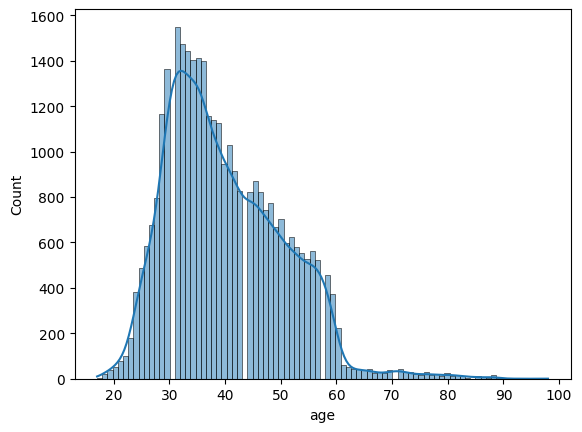

In [ ]:
sns.histplot(df_new['age'], kde=True)  # Create histogram
plt.show()  # Show plot

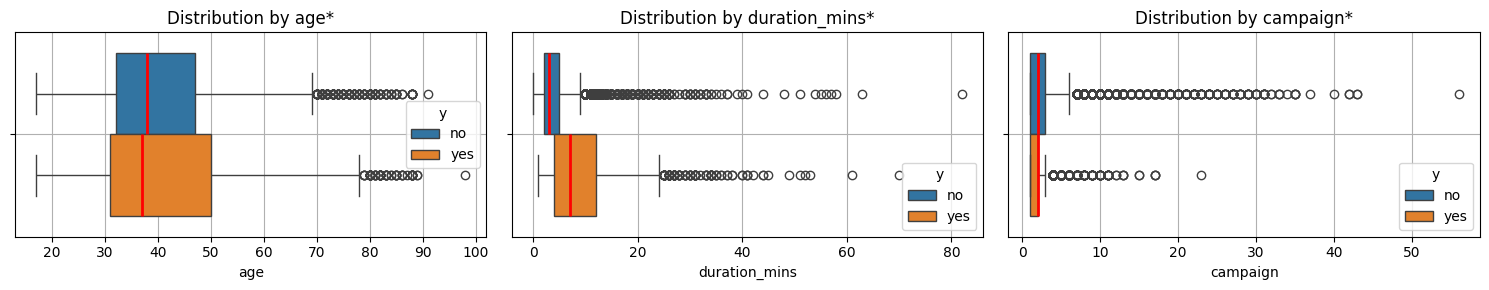

In [ ]:
cf.plot_boxplots(df_new,
            columns=['age', 'duration_mins', 'campaign'], 
            target='y',
            figsize=(15, 3), 
            subplot_grid_size=(1, 3))

##### Key Observations

The boxplots reveal the following patterns:

1. **Age**:
    - Age distribution is relatively similar for both groups, with a slight skew towards younger individuals agreeing to make a deposit.
    - Outliers seem to be common in both groups.

2. **Contacts during current compaign**:
    - Higher number of phone call during the current campaign may not necessarily lead to a positive outcome. Moreover, there are more outliers in the "no" group, suggesting that after some point repeated simply lose their effectiveness.
    
3. **Previous Contact attempts**:
    - The number of contacts during previous campaigns shows to be associated with minor positive influence over the 'yes' group. This indicates that previous contact history might to some degree have a positive influence on the likelihood of agreeing to a deposit.

4. **Call Duration (in minutes)**:
    - Longer calls seem to positive affect one's willingness to deposit, suggesting that engagement during the call is a critical factor.

### Assessment of Caterorical features

Similar to boxplots, barplots provide a visual representation of the distribution of categorical features segmented by the target variable 'y'. This helps in understanding how these categorical features vary between individuals who agreed to make a deposit ('yes') and those who did not ('no').

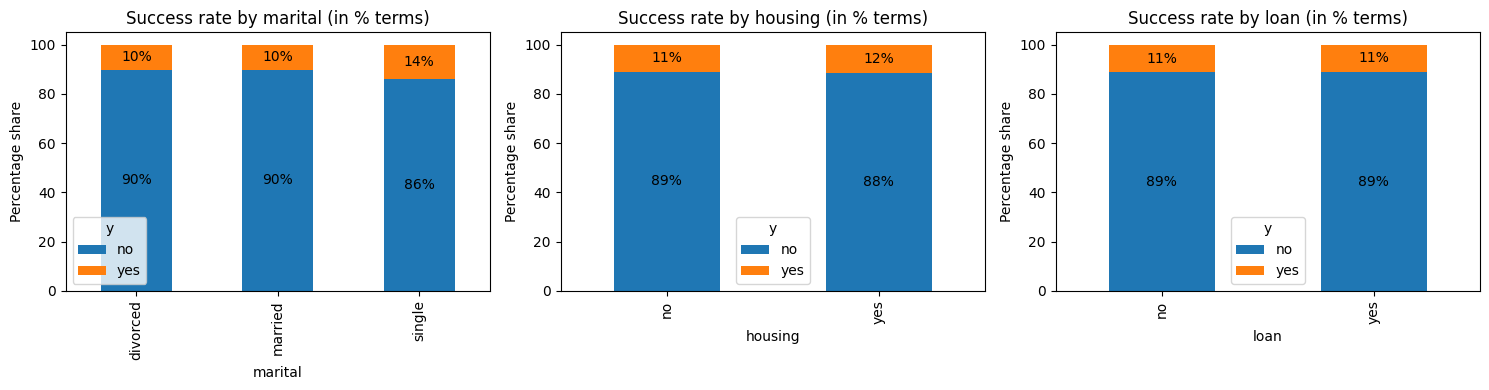

In [ ]:
# Analyze the relationship between the willingness to deposit and current financial situation
cf.show_categorical_correlation(
    df_new,
    target='y', 
    cols_to_consider=['marital','housing', 'loan'], 
    figsize=(15, 4),
    subplot_grid_size=(1, 3),
    show_details=False, 
    annotate=True
)


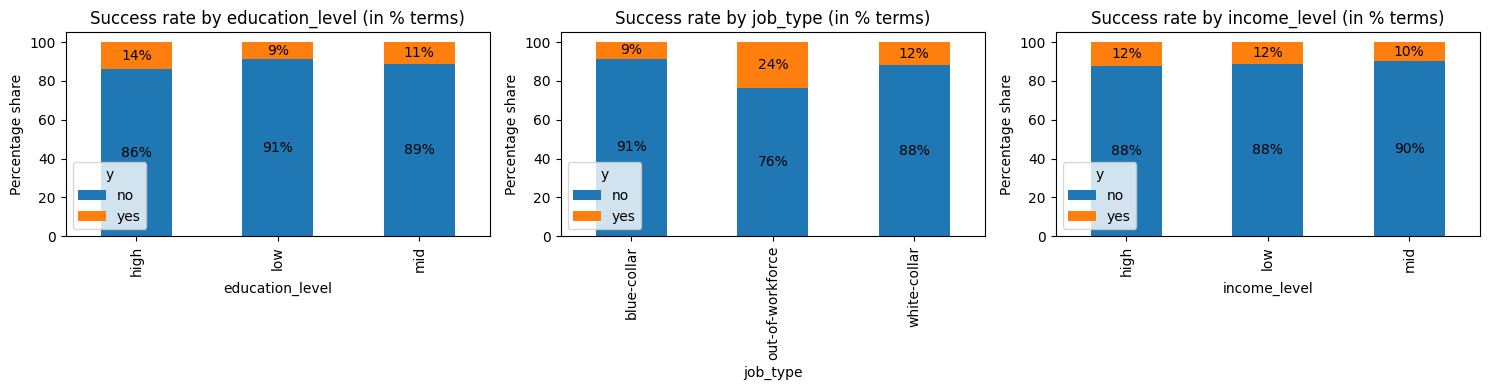

In [79]:
# Analyze the relationship between the willingness to deposit and people's social status
cf.show_categorical_correlation(
    df_new,
    target='y', 
    cols_to_consider=['education_level','job_type', 'income_level'], 
    figsize=(15, 4),
    subplot_grid_size=(1, 3),
    show_details=False, 
    annotate=True
)

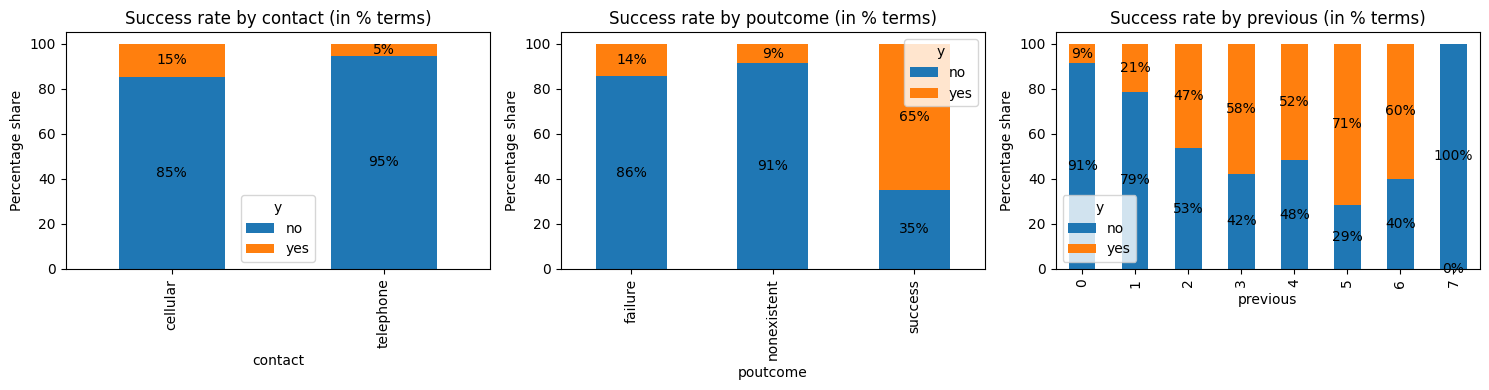

In [111]:
# Analyze the relationship between the willingness to deposit and other factors
cf.show_categorical_correlation(
    df_new,
    target='y', 
    cols_to_consider=['contact','poutcome', 'previous'], 
    figsize=(15, 4),
    subplot_grid_size=(1, 3),
    show_details=False, 
    annotate=True
)

#### Key Observations
<details>

1. **Marital Status**:
    - The distribution of marital status is relatively similar between the two groups.
    - Married individuals form the largest group in both 'yes' and 'no' categories, followed by single and divorced individuals.

2. **Housing**:
    - A higher proportion of individuals without housing loans agreed to make a deposit compared to those with housing loans.
    - This suggests that individuals without housing loans might be more inclined to make a deposit.

3. **Loan**:
    - The presence of personal loans shows a slight difference between the two groups.
    - Individuals without personal loans are more likely to agree to make a deposit compared to those with personal loans.

</details>

> Now, once data is believed to be high-quality enough, let's save new dataframe to a local file and/or database

In [ ]:
# List of columns to keep
useful_cols = ['age', 'marital',  'education_level', 'job_type', 'income_level', 'housing', 'loan',               
    'contact', 'day_of_week', 'duration_mins', 'campaign', 'previous', 'poutcome', 'y'
]